<a href="https://colab.research.google.com/github/wzy816/fundamentals/blob/master/028.kalman.filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kalman Filter

KF is also known as `linear gaussian state space model`. 

## Definition

$$ z_{t} = A * z_{t-1} + \mathcal{N} (0,Q) $$
$$ x_{t} = C * z_{t} + \mathcal{N} (0,R)$$

where `z` is the hidden state, `x` is the observation, `A` is the transition matrix, `C` is the observation matrix


In [32]:
# build lgssm model
import tensorflow_probability as tfp
import tensorflow as tf
STEPS = 100

# assume observation_size_ = latent_size_ = 2
model= tfp.distributions.LinearGaussianStateSpaceModel(
  num_timesteps = STEPS,
  transition_matrix = tf.linalg.LinearOperatorIdentity(num_rows=2, dtype=tf.float32), # ===[2,2] shape [-2:] should be [latent_size_, latent_size_]
  transition_noise = tfp.distributions.MultivariateNormalDiag(scale_diag=tf.ones([BATCH_SIZE,2])), # event_shape = 2 should be [latent_size_] 
  observation_matrix = tf.linalg.LinearOperatorIdentity(num_rows=2, dtype=tf.float32), # ===[2,2] shape[-2:] should be [observation_size_, latent_size_],
  observation_noise = tfp.distributions.MultivariateNormalDiag(scale_diag=tf.ones([BATCH_SIZE,2])), # event_shape = 2 should be [observation_size_]
  initial_state_prior = tfp.distributions.MultivariateNormalDiag(loc=[0], scale_diag=tf.ones([BATCH_SIZE,2])) # event_shape = 2 should be [latent_size_] 
)

(1, 100, 2)
tf.Tensor([-375.8311], shape=(1,), dtype=float32)


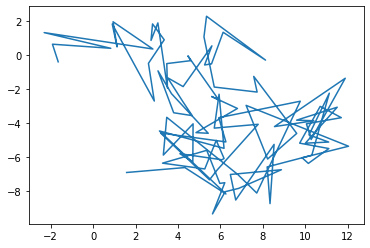

In [33]:
# try sample and log_prob
import matplotlib.pyplot as plt

x = model.sample()  # sample from initial_state_prior
print(x.shape)

for series in x:
    plt.plot(series[:,0],series[:,1]) # plot 100-step path
    print(model.log_prob(series)) # Marginal likelihood of one observations.

tf.Tensor(
[[ -113.33421      -6.3162336   -61.343853   -804.65607      -8.369524
   -211.06055      -3.490673    -15.205041   -215.81462    -207.75856
   -252.8437       -6.269712   -373.391      -237.97179     -39.203693
   -167.7256     -113.85335    -491.90808    -221.94635    -331.18124
     -8.188375    -14.323061    -94.25382    -503.50317     -47.612602
   -305.4148     -178.04425    -543.2956      -19.103033   -652.13153
    -64.05768    -177.24445    -422.52756     -57.149395     -5.790439
   -370.01996     -56.557167    -12.322668   -740.01483    -154.60898
   -529.17523      -9.616253    -46.384426   -326.9803      -58.04861
   -689.8786      -16.928753   -415.3738     -272.68225    -823.1704
   -175.48868     -53.18212     -30.2249     -327.96533    -267.27945
   -127.98041    -672.156       -75.501366    -77.350464    -75.08701
   -496.97525    -181.38382     -16.201717    -18.877272   -313.60654
   -105.013535   -395.70163      -4.0843267    -5.999537   -175.9974
    -82

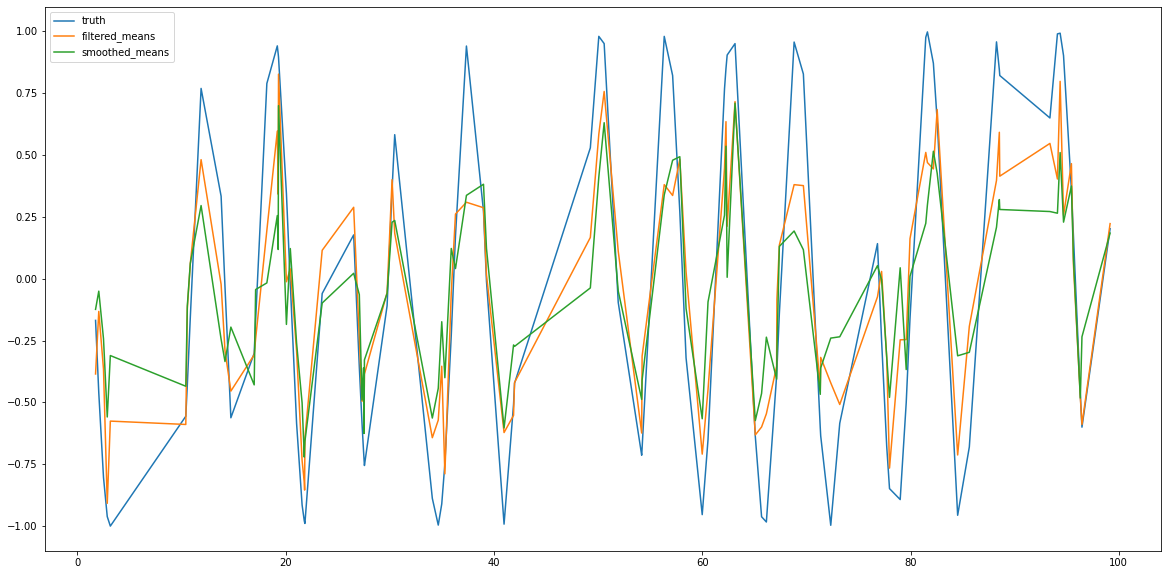

In [34]:
# build fake sine data
import seaborn as sns
import numpy as np

def gen():
    x = np.random.rand(STEPS).astype(np.float32) * STEPS
    return np.array([x, np.cos(x)])

d = next_batch()
        
# passes, *_means === [BATCH_SIZE, STEPS, 2], *_covs === [BATCH_SIZE, STEPS, 2]
# opt 1 with intermediate results
log_likelihoods, filtered_means, filtered_covs, predicted_means, predicted_covs, observation_means, observation_covs = model.forward_filter(d)
smoothed_means, smoothed_covs = model.backward_smoothing_pass(filtered_means, filtered_covs, predicted_means, predicted_covs)

# opt 2 without intermediate results
# smoothed_means, smoothed_covs = model.posterior_marginals(d)

# plot
print(log_likelihoods)
print(filtered_means[:,:,1].numpy().mean(axis=0))
print(smoothed_means[:,:,1].numpy().mean(axis=0))

plt.figure(figsize=(20,10))
sns.lineplot(x=d[0,:,0],y=d[0,:,1], label='truth')
sns.lineplot(x=d[0,:,0],y=filtered_means[:,:,1].numpy().mean(axis=0), label='filtered_means')
sns.lineplot(x=d[0,:,0],y=smoothed_means[:,:,1].numpy().mean(axis=0), label='smoothed_means')